# Modeling Section #

In this section, I'm going to try some different models for explaining and predicting track duration and popularity behavior over the years, also using other variables such as valence and energy to find a model that can be well fit to the dataset. 

### Collecting packages

In [34]:
# Collecting packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, round

### Starting Spark Context and Spark Session

In [2]:
# Configure SparkUI
conf = SparkConf().set('spark.ui.port', '4050')

# Create a URL through you can access the Spark UI
get_ipython().system_raw('./ngrok http 4050 &')

# Access the URL
!curl -s http://localhost:4040/api/tunnels 

# Creating a context. Access SparkUI now in localhost:4050
sc = SparkContext(conf=conf)

In [3]:
# Starting Spark Session
spark = (
    SparkSession.builder                  
      .config('spark.ui.port', '4050')
      .appName("music_spark_session")
      .getOrCreate()
)

### Collecting clean data from data preparation section

In [9]:
path_data = "clean_data_music.csv"

schema_music = StructType([
    StructField('Index', IntegerType()),
    StructField('Track_duration', IntegerType()),
    StructField('Popularity', IntegerType()),
    StructField('Danceability', DoubleType()),
    StructField('Energy', DoubleType()),
    StructField('Key', IntegerType()),
    StructField('Loudness', DoubleType()),
    StructField('Acousticness', DoubleType()),
    StructField('Instrumentalness', DoubleType()),
    StructField('Liveness', DoubleType()),
    StructField('Valence', DoubleType()),
    StructField('Tempo', DoubleType()),
    StructField('Year', IntegerType())
])


In [66]:
df = spark.read.csv(
    path_data,
    header=True,
    sep=',',
    schema=schema_music
).drop('index')

In [67]:
df.show()

+--------------+----------+------------+------+---+--------+------------+----------------+--------+-------+-------+----+
|Track_duration|Popularity|Danceability|Energy|Key|Loudness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Year|
+--------------+----------+------------+------+---+--------+------------+----------------+--------+-------+-------+----+
|        216270|         0|       0.617| 0.872|  8| -12.305|      0.0158|           0.112|   0.408|  0.504|111.458|1992|
|        237120|        64|       0.825| 0.743|  2|  -5.995|      0.0142|         2.12E-5|   0.237|    0.8|127.045|2009|
|        312533|        56|       0.677| 0.665|  7|  -5.171|        0.56|         1.01E-6|   0.338|  0.706| 74.981|1999|
|        233400|        42|       0.683| 0.728|  9|   -8.92|       0.568|         5.08E-5|  0.0384|  0.833| 75.311|2014|
|        448720|         0|       0.319| 0.627|  0|  -9.611|       0.675|         7.29E-5|   0.289|  0.497| 85.818|1969|
|        193346|        79|     

### Fit track duration average by year with non linear model

In [68]:
df_track_dur = df.select('Year', 'Track_duration')\
                 .groupBy('Year').avg('Track_duration').orderBy('Year')\
                 .withColumnRenamed('avg(Track_duration)', 'Track_duration')\
                 .withColumn('Track_duration', round(col('Track_duration'), 2))


In [79]:
df_track_dur = df_track_dur.toPandas()

In [81]:
df_track_dur.head(10)

,Year,Track_duration
0,1956,119200.00
1,1958,139411.91
2,1959,227953.00
3,1960,162591.80
4,1961,160295.55
5,1962,152770.45
6,1963,153689.96
7,1964,155397.08
8,1965,176746.79
9,1966,162602.03


In [92]:
from sklearn.linear_model import LinearRegression

X = df_track_dur.drop('Track_duration', axis = 1).copy()
y = df_track_dur['Track_duration'].copy()

linear_reg = LinearRegression()
linear_reg.fit(X, y);

Ajusting with Polynomial, with 3rd degree curve

In [93]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)

X_poly = poly_features.fit_transform(X)

In [94]:
linear_reg.fit(X_poly, y)

y_pred_poly = linear_reg.predict(X_poly)

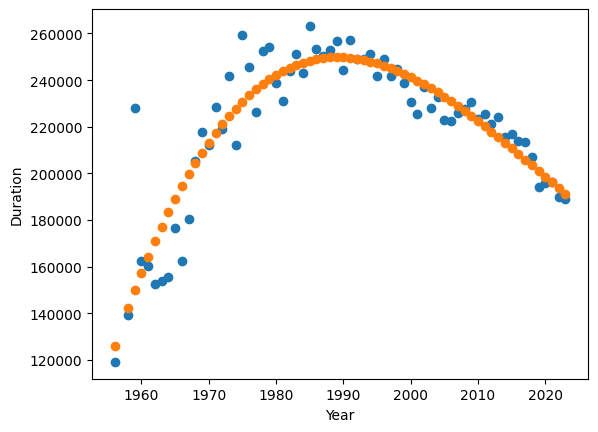

In [110]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.scatter(X, y_pred_poly)
plt.xlabel('Year')
plt.ylabel('Duration');